# Praktikum 1: Rule‑Based Spam Filter — Baseline

**Learning goals for this notebook**
1. Load a small email dataset.
2. Implement a rule-based spam filter.
3. Compute baseline metrics (accuracy & confusion matrix).
4. Introduce a text-processing pipeline
5. Reflect on performance and weakneses 

## Loading libraries
In the repository, you will find the scripts to install the dependencies required for this lab under the `/scripts` folder. 
- If you are in a YourAI cluster node, make sure to run the `install_env.sh` script to download additional dependencies. 
- If you are in `google collabs`, open the terminal and load the commands in the `install_google_collabs.sh`.

In [29]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, ConfusionMatrixDisplay
from datasets import load_dataset, load_from_disk

## Task 1. Loading and exploring data
**Goal**: explore the SMS spam dataset and report basic dataset facts. 

**Deliverable**: Keep the code cells to perform the following operations:

1. Obtain the number of examples (rows) in the chosen split ('train').  
3. Get information about class distribution: counts for each label value (e.g., spam vs ham).  
4. Show 5 representative examples (text + label) from the dataset.
5. Remove duplicates, and keep the dataframe to only the spam and english sms message.

In [31]:
ds = load_dataset("dbarbedillo/SMS_Spam_Multilingual_Collection_Dataset")
df =  ds["train"].to_pandas()

In [33]:
# Your exploration starts here...

## Task 2. Text preprocessing pipeline
**Goal:** implement a text processing pipeline that can serve as input to the spam detection rules.

Try and compare the effect of several common preprocessing steps (apply them incrementally and record the effect on task 4):

1. **Encoding / Unicode normalization** (e.g. NFKC/NFC)  
2. **Case folding** (use `.casefold()` rather than `.lower()` for Unicode-safe caseless matching)  
3. **Lemmatization:** stemming / lemmatization — choose one and justify the choice for this rule-based setup

Use the `ntlk` library as the main reference, so that we internalize the implementation of the pipeline and its steps.

**Deliverable:** a single function `text_processing(text)` and a short note (1–2 sentences) describing which steps you enabled and why. 

In [ ]:
import unicodedata
import nltk
from nltk.corpus import wordnet
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk import pos_tag
import re

stemmer = SnowballStemmer("english")
wnl = WordNetLemmatizer()

def treebank_to_wordnet_pos(treebank_tag: str):
    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

def normalize_encoding(text: str) -> str:
    # some relevant enconding operations..
    return unicodedata.normalize('NFKC', text)
    
# Let's use nltk 
def text_processing(text) :
   
    # 1) sentence segmentation on original text (we keep original for display)
    sentences = sent_tokenize(text, language='english')  

    out = []
    
    for sent in sentences:
        sent_clean  = normalize_encoding(sent)

        # 2) tokenize (on the cleaned sentence but preserve original token text for some checks)
        tokens = re.findall(r"\b\w[\w'\-]*\b", sent_clean) # to be replaced by nltk's tokenizer

        # 3) POS tagging (POS taggers expect cased text; we used cleaned but not casefolded text)
        tagged = pos_tag(tokens)            
        
        # 4) lemmatization/stemming per token (use POS for better lemmas)
        token_dicts = []
        for tok, tb_pos in tagged:
            wn_pos = treebank_to_wordnet_pos(tb_pos)
            lemma = wnl.lemmatize(tok, pos=wn_pos)
            token_info = {
                'text' : tok,
                'lemma' : "",
                'stem' : "",
                'casefold' : "",
                'is_alpha': tok.isalpha(),
                'is_digit': tok.isdigit(),
                'is_allcaps': tok.isupper(),                
            }
            token_dicts.append(token_info)
            
        out.append({
            'sentence_raw' : sent,
            'sentence_clean' : sent_clean,
            'tokens': token_dicts
        })
    return out
    
text_processing("You have won a prize! Claim your gift now.")   

[{'sentence_raw': 'You have won a prize!',
  'sentence_clean': 'You have won a prize!',
  'tokens': [{'text': 'You',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha': True,
    'is_digit': False,
    'is_allcaps': False},
   {'text': 'have',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha': True,
    'is_digit': False,
    'is_allcaps': False},
   {'text': 'won',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha': True,
    'is_digit': False,
    'is_allcaps': False},
   {'text': 'a',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha': True,
    'is_digit': False,
    'is_allcaps': False},
   {'text': 'prize',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha': True,
    'is_digit': False,
    'is_allcaps': False}]},
 {'sentence_raw': 'Claim your gift now.',
  'sentence_clean': 'Claim your gift now.',
  'tokens': [{'text': 'Claim',
    'lemma': '',
    'stem': '',
    'casefold': '',
    'is_alpha'

## Task 3. Rule-based spam filter
**Goal:** implement `predict_spam_rule(text) -> 1|0` using concise, interpretable rules.

- Apply rules on the **canonicalized** text where appropriate (token/phrase rules), but you may also consult the raw text for punctuation-intensity or ALL-CAPS heuristics.
- Keep each rule explainable — a short comment for each rule explaining the intuition is required.

**Starter rule ideas**
- keyword/phrase spotting (single tokens and short n-grams)  
- currency / money patterns (`$1000`, `1,000.00`, `usd`)  
- URL / domain / phone patterns  
- punctuation intensity (many `!`) or suspicious non-alphanumeric runs  
- simple ALL-CAPS heuristic (e.g., >50% tokens uppercase)

**Extension:** add one sentence-level check (negation handling or quoted text exceptions) to reduce obvious false positives.

**Deliverable:** the `predict_spam_rule` function plus a short comment block listing the rules and the rationale for each.

In [76]:
import re
from typing import Tuple, Dict, List

CURRENCY_RE = re.compile(r'\$\s*\d+|\b\d{1,3}(?:,\d{3})*(?:\.\d{2})?\s?(?:usd|eur|dollars)?\b', re.I)
TOK_SPAM_SET = {"free", "win", "prize"}

def predict_spam_rule(text: str) -> int:
    pred, reason = predict_spam_rule_details(text)
    return pred

def predict_spam_rule_details(text: str) -> Tuple[int, Dict]:
    """
    Returns (prediction, details) where details contains:
      - 'fired_rule': one of 'token', 'lemma', 'phrase', 'currency', 'url', 'phone',
                      'exclam', 'allcaps', 'suspicious_punct', or None
      - 'fired_detail': extra info (token/lemma/phrase/regex match)
    """
    details = {'fired_rule': None, 'fired_detail': None}
    
    # get sentence-level structures
    sentences = text_processing(text)

    for sent in sentences:        
        if CURRENCY_RE.search(sent['sentence_clean']):
            details.update({'fired_rule':'currency', 'fired_detail': CURRENCY_RE.search(sent['sentence_clean']).group(0)})
            return 1, details

        # At the token level
        tokens = sent['tokens']
        for tok in tokens:
            # check the text
            tok_text = tok.get('casefold') or tok.get('text')
            if tok_text in TOK_SPAM_SET:
                details.update({'fired_rule': 'token', 'fired_detail': tok_text})
                return 1, details
            
            # check the lemma
            lemma = tok.get('lemma') 
            if lemma and lemma.casefold() in TOK_SPAM_SET:
                details.update({'fired_rule': 'lemma', 'fired_detail': lemma})
                return 1, details            
    return 0, details

predict_spam_rule_details("You have won a prize! Claim your gift now.")

(1, {'fired_rule': 'token', 'fired_detail': 'prize'})

## Task 4. Apply rules to the dataset & evaluate 
**Goal:** measure how your rules perform on real data and iterate.

- Apply your rule to each example in the chosen split ('train')
- Compute and report standard metrics: **TP, FP, FN, TN**, **precision**, **recall**, and **F1**. 
- When you change preprocessing or rules, keep a log (table) of the metric values so you can show the effect of each change (an ablation table is ideal -- effect of individual).

**Deliverable:** one small results table showing baseline (no preprocessing), + preprocessing variants, and + rule changes; print the confusion counts for the final rule.


In [77]:
y_pred = df["text"].apply(predict_spam_rule)
y_pred.value_counts()

text
0    4358
1    1214
Name: count, dtype: int64

Accuracy: 0.8548097631012204
              precision    recall  f1-score   support

         ham       0.96      0.87      0.91      4825
        spam       0.47      0.77      0.59       747

    accuracy                           0.85      5572
   macro avg       0.72      0.82      0.75      5572
weighted avg       0.90      0.85      0.87      5572



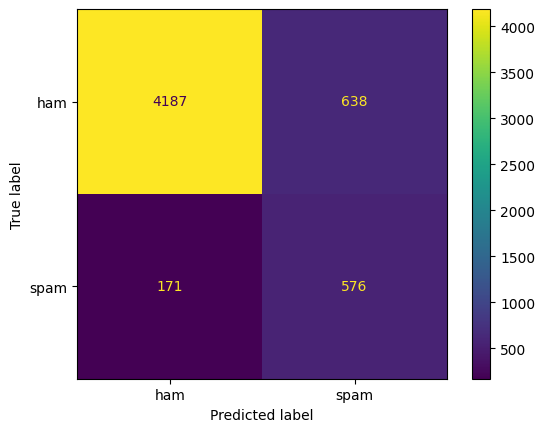

In [78]:
# Ground-truth labels
y_true = df["labels"] == "spam"

# Overall correctness
print('Accuracy:', accuracy_score(y_true, y_pred))

# Detailed metrics (precision, recall, F1) for each class.
# `target_names` provides human-readable labels in the SAME order scikit-learn uses:
# here 0 → 'ham', 1 → 'spam'.  If we ever swap the class order, we’d pass `labels=[1,0]`
# and provide target_names=['spam', 'ham'] in that matching order.
print(classification_report(y_true, y_pred,
                            target_names=['ham', 'spam']))


# 2×2 matrix: [[TN, FP], [FN, TP]]
cm = confusion_matrix(y_true, y_pred)

ConfusionMatrixDisplay(confusion_matrix=cm,
                       display_labels=['ham', 'spam']).plot()


## Task 5. Error analysis & short write-up
**Goal:** understand failure modes and propose concrete, explainable improvements.

- Inspect **false negatives** (spam missed) and **false positives** (ham flagged). For each selected example write 1–2 sentences:  
  - *Why* did the rule fail? (missing keyword, obfuscation, negation, ambiguity, etc.)  
  - *How* would you change the rules or preprocessing to fix it (concrete change, not vague intuition)?
- Compare evaluation **with** and **without** the preprocessing pipeline you implemented and summarize how canonicalization affected precision / recall.

**Deliverable:** a short markdown cell with at least **3 examples** (FP or FN) and your proposed fix for each, plus a 2–3 sentence summary of the overall effect of preprocessing.


In [79]:
errors = [(i, t, g, p) for i,(t,g,p) in enumerate(zip(df['text'], y_true, y_pred)) if g != p]
# show up to 10 examples (fp then fn)
fps = [e for e in errors if e[2]==0 and e[3]==1]
fns = [e for e in errors if e[2]==1 and e[3]==0]

print("Example false positives:")
for i, t, g, p in fps[:5]:
    print(i, t, "gold=0 pred=1")
    print("-> text:", t)
    print("---")

print("\nExample false negatives:")
for i, t, g, p in fns[:5]:
    print(i, t, "gold=1 pred=0")
    print("-> text:", t)
    print("---")

Example false positives:
7 As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune gold=0 pred=1
-> text: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune
---
17 Eh u remember how 2 spell his name... Yes i did. He v naughty make until i v wet. gold=0 pred=1
-> text: Eh u remember how 2 spell his name... Yes i did. He v naughty make until i v wet.
---
21 I‘m going to try for 2 months ha ha only joking gold=0 pred=1
-> text: I‘m going to try for 2 months ha ha only joking
---
23 Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already? gold=0 pred=1
-> text: Aft i finish my lunch then i go str down lor. Ard 3 smth lor. U finish ur lunch already?
---
31 Yeah he got in at 2 and was v apologetic. n had fallen out and she was actin like spoilt chil

## General notes

### Success criteria (use for self-check)
- **Task A:** preprocessing function implemented and tested on at least two examples.  
- **Task B:** `predict_spam_rule` implemented; rules are concise and commented.  
- **Task C:** metrics computed and a short ablation table showing iterations.  
- **Task D:** at least 3 error examples analyzed with concrete fixes proposed.


**Submission:** ensure the notebook contains: (1) your `canonicalize_for_rules`, (2) `predict_spam_rule`, (3) evaluation table and confusion counts, and (4) the error-analysis markdown cell described above.


## Bonus
Implement the same approach on the german sms texts